#MUCAD-CLF Description
As Onshape Analytics provides a rich but enormous dataset -- logging all user actions in an Onshape document -- it can be challenging to efficiently visualize and compare the data of different users. We first adapted and developed two action classification methods in this framework to organize and count the recorded action data in several meaningful categories. Then, we generated script for creatively plotting the counts for visaulization and comparison. A full description and demonstration of the framework is published in this [journal paper](https://doi.org/10.1016/j.aei.2021.101446). 

Deng Y, Mueller M, Rogers C, Olechowski A. The Multi-User Computer-Aided Design Collaborative Learning Framework. _Adv Eng Informatics_. 2022;51:101446. doi:10.1016/j.aei.2021.101446


**Design Space Classification**

<p align="center">
<img src="https://drive.google.com/uc?id=1tZm5u4xv2Ec29TmHgHrUO0qkeJoRKh9m" width="500">
</p>

**Action Type Classification**

<p align="center">
<img src="https://drive.google.com/uc?id=1JvZpsVKoGAlRLqlxe17l_Yvb4J7MixOb" width="500">
</p>

Using the Action Type Classification, the **creation/revision ratio (CR ratio)** is defined to be $\text{CR Ratio}=\frac{\text{# of creating actions}}{\text{# of revising actions}}$

#Audit Trails Preparation
Please follow the following procedures to download and prepare audit trails from your Onshape Enterprise account for analysis. Plots to be generated will be used to compare data between each audit trail analyzed. It is recommended to download audit trails separately for each file and/or user to be analyzed. 

1. Download audit trails from your Onshape Enterprise account as **csv files** as shown in the images below. (Note: please use the method outlined below, otherwise the downloaded audit trail may only contain a maximum of 500 entries.) 
- Filter out the audit trails from the file and/or user to be analyzed. 

<p align="center">
<img src="https://drive.google.com/uc?id=1Mu5DwJcrqNG43tz5vFBthUOx_xDchNde" width="500">
</p>

- Select the appropriate format of audit trails to be downloaded and specify filenames (will be used for plotting). 

<p align="center">
<img src="https://drive.google.com/uc?id=1ZcJ2sccl5pxHK6503E6WORgSgWWW2qhJ" width="500">
</p>

2. Unzip the downloaded files and organize all csv files (the audit trails) in **one folder**. 
3. Upload and provide access to the folder using **one of the two methods**. 

##Option 1 
Upload the audit trails to your Google Drive **as a folder**, and then run only code for Option 1 to mount this notebook to your Drive. 

In [ ]:
# Option 1: upload to Google Drive and mount this notebook to your Drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Option 2 
1. Compress the folder containing all the audit trails as a zip file. 
2. Run only code for Option 2 to directly upload the zip file to the hosted runtime of this notebook (files will not be saved once you close this browser window). 

In [ ]:
# Option 2: upload directly to this notebook
from google.colab import files
uploaded = files.upload()

Saving audit_trails.zip to audit_trails.zip


3. Locate the file as shown in the image below and copy the path of the file to the code below after "!unzip". 

<p align="center">
<img src="https://drive.google.com/uc?id=1NyrTu4QckDMjyS4onrfFf8hjw63bpe6b" width="500">
</p>

4. Run the code below to unzip the files as a folder. 

In [ ]:
!unzip /content/audit_trails.zip

Archive:  /content/audit_trails.zip
   creating: audit_trails/
  inflating: audit_trails/.DS_Store  
  inflating: __MACOSX/audit_trails/._.DS_Store  
  inflating: audit_trails/User1.csv  
  inflating: __MACOSX/audit_trails/._User1.csv  
  inflating: audit_trails/User2.csv  
  inflating: __MACOSX/audit_trails/._User2.csv  


#Locating Directory
To locate the directory of the uploaded folder, containing all the audit trails for analysis, please follow the instructions below: 
* For uploading Option 1 above: locate the audit trails folder in "MyDrive" and copy the path of the folder as the directory. 
* For uploading Option 2 above: copy the path of the unzipped folder as the directory. 

With the path copied, paste it to the **`audit_trails_directory`** variable in the MUCAD-CLF code form below. 

<p align="center">
<img src="https://drive.google.com/uc?id=1kWrAL_nZS8QsNi0r_57hcBVDPZJhPEqO" width="500">
</p>



#MUCAD-CLF Code

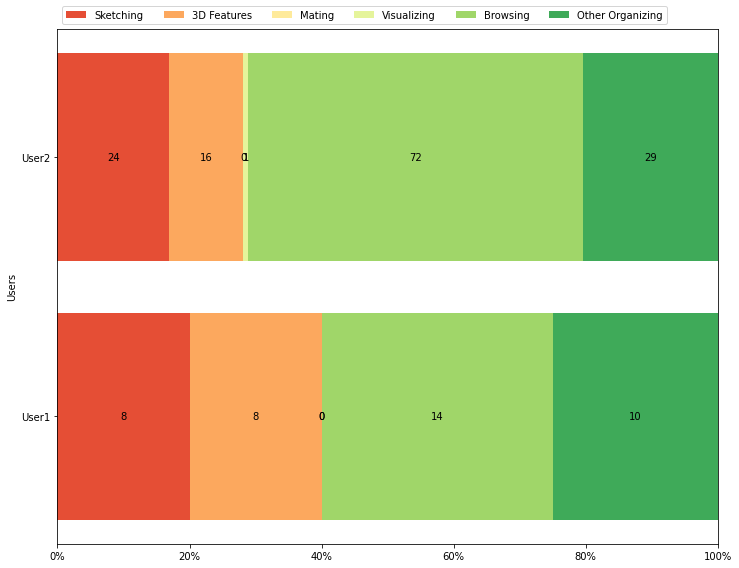

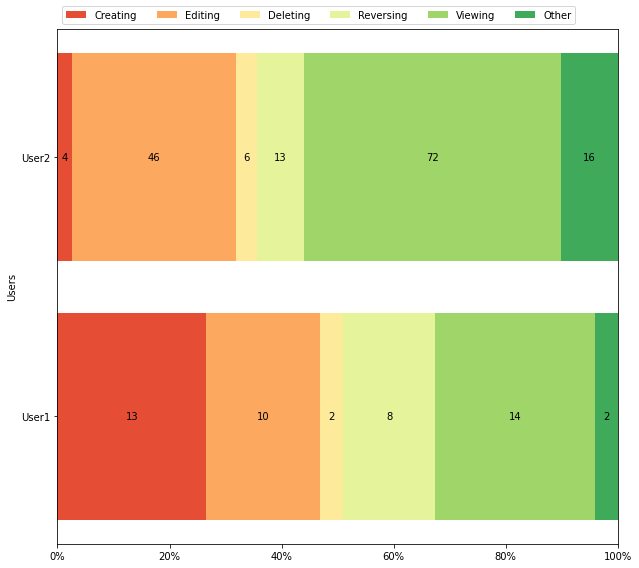

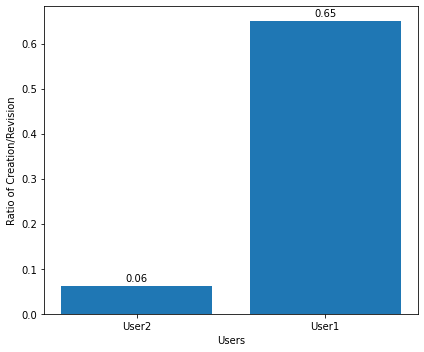

In [3]:
#@markdown ---
#@markdown Copy the directory path to the folder that contains all the audit trails for analysis
audit_trails_directory = '/content/drive/MyDrive/audit_trails'  #@param {type: "string"}
#@markdown Please specify the types of plots you would like to generate and adjust figure size if necessary: 
plot_design_space_percentage = True  #@param {type: "boolean"}
dsp_width =   10.5#@param {type: "number"} # default 10.5
dsp_height =   8#@param {type: "number"} # default 8 
plot_action_type_percentage = True  #@param {type: "boolean"} 
atp_width =   9#@param {type: "number"} # default 9 
atp_height =   8#@param {type: "number"} # default 8 
plot_cr_ratio = True  #@param {type: "boolean"}
crr_width = 6  #@param {type: "number"} # default 6 
crr_height = 5  #@param {type: "number"} # default 5
#@markdown If multiple users are found in one audit trail, would you like them to be counted separately?
separate_users = False  #@param {type: "boolean"} 
#@markdown For the plots, would you like the files/participants on the plot be ordered by number of actions, 
#@markdown or be ordered alphabetically by default? 
order_by_count = True  #@param {type: "boolean"}
#@markdown ---

import os 
import csv 
import pandas as pd
import numpy as np
from typing import List, Tuple, Dict, Union
import matplotlib.pyplot as plt
from matplotlib import ticker

def classify_design_space(action: str) -> int:
    """
    The returning index corresponds to the list stored in "count":
    [sketching, 3D features, mating, visualizing, browsing, other organizing]

    Formulas for each design space action:
        sketching = "Add or modify a sketch" + "Copy paste sketch"
        3D features = "Commit add or edit of part studio feature" + "Delete part studio feature"
                    - "Add or modify a sketch"
        mating = "Add assembly feature" + "Delete assembly feature" + "Add assembly instance"
                    + "Delete assembly instance"
        visualizing = "Start assembly drag" + "Animate action called"
        browsing = Opening a tab + Creating a tab + Deleting a tab + Renaming a tab
        other organizing = "Create version" + "Cancel Operation" + "Undo Redo Operation"
                    + "Merge branch" + "Branch workspace" + "Update version"

    :param action: the action to be classified
    :return: the index of the action type that this action is accounted for; if the action does not
            belong to any category, return -1

            Note:   "Add or modify a sketch" is special (+1 for sketching and -1 for 3D features),
                    return -10
    """
    # Creating a sketch is special as it affects both the sketching and the 3D features counts
    if action == "Add or modify a sketch":
        return -10
    # Sketching
    elif action == "Copy paste sketch":
        return 0
    # 3D features
    elif action in ["Commit add or edit of part studio feature",
                    "Delete part studio feature"]:
        return 1
    # Mating
    elif action in ["Add assembly feature", "Delete assembly feature", "Add assembly instance"
                    "Delete assembly instance"]:
        return 2
    # Visualizing
    elif action in ["Start assembly drag", "Animate action called"]:
        return 3
    # Browsing
    elif "Tab" in action and ("opened" in action or "created" in action or "deleted" in action or
                              "renamed" in action):
        return 4
    # Other organizing
    elif action in ["Create version", "Cancel Operation", "Undo Redo Operation", "Merge branch",
                    "Branch workspace", "Update version"]:
        return 5
    # Not classified (Optional: print out the unclassified actions)
    else:
        return -1

def classify_action_type(action: str) -> int:
    """
    The returning index corresponds to the list stored in "count":
    [creating, editing, deleting, revising, viewing, other]

    Formulas for each design space action:
        creating = "Add part studio feature" + "Add assembly feature" + "Add assembly instance"
                    + "Copy paste sketch"
        editing = "Start edit of part studio feature" + "Start edit of assembly feature"
                    + "Set mate values"
        deleting = "Delete part studio feature" + "Delete assembly feature"
                    + "Delete assembly instance"
        revising = "Cancel Operation" + "Undo Redo Operation"
        viewing = Opening a tab + "Animate action called"
        other = Creating a tab + Deleting a tab + "Create version" + Renaming a tab
                    + "Merge branch" + "Branch workspace" + "Update version"

    :param action: the action to be classified
    :return: the index of the action type that this action is accounted for; if the action does not
            belong to any category, return -1
    """
    # Creating
    if action in ["Add part studio feature", "Add assembly feature", "Add assembly instance",
                  "Copy paste sketch"]:
        return 0
    # Editing
    elif action in ["Start edit of part studio feature", "Start edit of assembly feature",
                    "Set mate values"]:
        return 1
    # Deleting
    elif action in ["Delete part studio feature", "Delete assembly feature",
                    "Delete assembly instance"]:
        return 2
    # Revising
    elif action in ["Cancel Operation", "Undo Redo Operation"]:
        return 3
    # Viewing
    elif action == "Animate action called" or ("Tab" in action and "opened" in action):
        return 4
    # Other
    elif action in ["Create version", "Merge branch", "Branch workspace", "Update version"] \
            or ("Tab" in action and
                ("created" in action or "deleted" in action or "renamed" in action)):
        return 5
    # Not classified (Optional: print out the unclassified actions)
    else:
        return -1

def aggregate_count(reader: iter, file_name: str) -> Dict:
    """
    Aggregate count of actions classified using the design space classification and the
    action type classification method.
    :param reader: the csv reader of the audit trail file.
    :param file_name: the name of the csv file that is being analyzed. 
    :return: a dictionary of counts for the file/each user in the file (depending on 
            if separate_users is selected); counts are stored a nested list of count 
            of actions classified using the design space and the action type 
            classification methods.

            List items in the output Dict correspond to the following count:
            [[sketching, 3D features, mating, visualizing, browsing, other organizing],
             [creating, editing, deleting, revising, viewing, other]]
    """
    empty_count = [[0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0]]
    next(reader)
    if not separate_users: 
        count = empty_count
    else: 
        count = {}
    for row in reader:
        """
        Each row has format: 
        ['Index', 'Event Time', 'Document', 'Tab', 'User', 'Description']
        Example: 
        ['1', '2021-08-21 19:12:19', 'Doc', 'N/A', 'x@x.com', 'Close document']
        """
        # Classify actions in design space
        design_space = classify_design_space(row[5].strip())
        if design_space != -1:
            if design_space == -10:  # the special "Add or modify a sketch" action
                if not separate_users: 
                    count[0][0] += 1
                    count[0][1] -= 1
                else: 
                    user = file_name + '/' + row[4].strip().split("@")[0]
                    if user not in count: 
                        count[user] = empty_count
                    count[user][0][0] += 1
                    count[user][0][1] -= 1
            else:
                if not separate_users: 
                    count[0][design_space] += 1
                else: 
                    user = file_name + '/' + row[4].strip().split("@")[0]
                    if user not in count: 
                        count[user] = empty_count
                    count[user][0][design_space] += 1
        # Classify actions in action type
        action_type = classify_action_type(row[5].strip())
        if action_type >= 0:
            if not separate_users: 
                count[1][action_type] += 1
            else: 
                user = file_name + '/' + row[4].strip().split("@")[0]
                if user not in count: 
                    count[user] = empty_count
                count[user][1][action_type] += 1
    if separate_users: 
        return count
    else: 
        return {file_name: count}

def _plot_percentage(df: pd.DataFrame, category_names: List[str], fig_size: Tuple[float]) -> None:
    """
    Internal function for plotting percentages of actions spent between different categories in
    category_names.
    :param df: data read from Counts.csv in pandas DataFrame
    :param category_names: categories of actions being considered and plotted
    :param fig_size: specified figure size in (width, height)
    :return: a plot is shown 
    """
    data = df[category_names].to_numpy(dtype=float)
    user_labels = df["File Name"].to_numpy(dtype=str)
    data_labels = df[category_names].to_numpy(dtype=int)
    for i in range(len(data)):
        temp_sum = sum(data[i])
        for j in range(6):
            data[i][j] /= temp_sum

    fig, ax = plt.subplots(figsize=fig_size)
    category_colors = plt.get_cmap('RdYlGn')(np.linspace(0.15, 0.85, data.shape[1]))  # Set colour

    ax.invert_yaxis()
    ax.set_xlim(0, 1)
    ax.set_ylabel("Users")
    data_cum = data.cumsum(axis=1)
    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(user_labels, widths, left=starts, label=colname, color=color)
        xcenters = starts + widths / 2
        for y, (x, c) in enumerate(zip(xcenters, widths)): 
            ax.text(x, y, data_labels[y, i], ha='center', va='center', color='black')
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1), loc='lower left')
    ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

    plt.tight_layout()
    plt.show()


def design_space_percentage(df: pd.DataFrame) -> None:
    """
    Visualize the percentage of actions spent in different design spaces
    :param df: data read from Counts.csv in pandas DataFrame
    :return: a plot is shown and saved if specified
    """
    category_names = ["Sketching", "3D Features", "Mating", "Visualizing", "Browsing",
                      "Other Organizing"]
    _plot_percentage(df, category_names, (dsp_width, dsp_height))


def action_type_percentage(df: pd.DataFrame) -> None:
    """
    Visualize the percentage of actions spent in different action types
    :param df: data read from Counts.csv in pandas DataFrame
    :return: a plot is shown and saved if specified
    """
    category_names = ["Creating", "Editing", "Deleting", "Reversing", "Viewing", "Other"]
    _plot_percentage(df, category_names, (atp_width, atp_height))

def cr_ratio(df: pd.DataFrame) -> None:
    """
    Visualize the creation/revision ratio of every individual user
    :param df: data read from Counts.csv in pandas DataFrame
    :return: a plot is shown and saved if specified
    """
    data = pd.DataFrame(df)
    data["cr"] = df["Creating"] / (df["Editing"] + df["Deleting"] + df["Reversing"])
    cr = df["cr"].to_numpy()
    user_labels = df["File Name"].to_numpy(dtype=str)

    fig, ax = plt.subplots(figsize=(crr_width, crr_height))

    ind = np.arange(len(user_labels))
    p = ax.bar(ind, cr)
    ax.set_ylabel('Ratio of Creation/Revision')
    ax.set_xticks(ind)
    ax.set_xticklabels(user_labels)
    ax.set_xlabel("Users")
    for rect in p:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Store the counts computed for each audit trail file
counts = {}

# Analyze all files in the "sample_audit_trails" folder
if audit_trails_directory[-1] == '/': 
    directory = audit_trails_directory
else: 
    directory = audit_trails_directory + '/'
for _, _, files in os.walk(directory):
    for File in files:
        if File.endswith(".csv"):
            with open(directory + File, 'r') as audit_trail_csv:
                reader = csv.reader(audit_trail_csv)
                counts = {**counts, **aggregate_count(reader, File[:-4])}

# Record counts in a new csv file
with open("Counts.csv", 'w') as record_csv:
    writer = csv.writer(record_csv)
    writer.writerow(["File Name", "Sketching", "3D Features", "Mating", "Visualizing",
                     "Browsing", "Other Organizing", "Creating", "Editing", "Deleting",
                     "Reversing", "Viewing", "Other", "Total"])
    for name, count_list in counts.items():
        temp = [name]
        temp.extend(count_list[0])
        temp.extend(count_list[1])
        temp.append(sum(count_list[1]))
        writer.writerow(temp)

count_data = pd.read_csv("Counts.csv")
if order_by_count: 
    count_data = count_data.sort_values(by=["Total"], ascending=False)

if plot_design_space_percentage: 
    design_space_percentage(count_data)
if plot_action_type_percentage: 
    action_type_percentage(count_data)
if plot_cr_ratio: 
    cr_ratio(count_data)

#Saving Analysis Results
After the above code is ran and plots are generated, there are several types of data that can be saved. 
1. Save the counts for all analyzed audit trails as a csv file. 

<p align="center">
<img src="https://drive.google.com/uc?id=1pTNx1OQAZTHxCIJlT77QZHRbdpo-JrEY" width="500">
</p>

2. Save the plots generated from running the code above. 

<p align="center">
<img src="https://drive.google.com/uc?id=15mpkYs1D7Mlv3Y9wvXyBDb9FsSYAA6Fu" width="500">
</p>
